# Generation Capacity Mixes
Version that uses Steve Colt's collected data


In [1]:
%%capture
# Import necessary packages
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Generation Capacity Mix
This section highlights the total yearly installed capacity for each of the ACEP regions from 2011 to 2021.

## Setting up the data

In [2]:
# Data gathered from Steve Colt's heavily modified version of the Energy Stats workbooks `./data/yearly-workbooks/energy-stats-colt-etf.xlsx`
# These data may have undergone manual fixes and modifications. Note data collected from the sheet: Table 1.d pivot and graphs
# Note that 2014-2017, 2019-2020 are missing and were never collected

# Loading and slicing data
a = pd.read_csv(
    os.path.join(os.curdir, "data", "installed-capacity-certified-utilities-mw.csv")
)
column_rename_dict = {
    "ff-turbines": "Fossil Turbine",
    "ff-ice": "Recip Engine",
    "hydro": "Hydro",
    "wind": "Wind",
    "solar": "Utility Solar",
    "storage": "Storage",
    "solar-btm": "Rooftop Solar",
    "landfill": "Landfill Gas",
}
a.rename(columns=column_rename_dict, inplace=True)

# Loading in the color schemes
schemes = json.load(open(os.path.join(os.curdir, 'color-schemes.json'))) # import the color schemes

In [3]:
# Collapsing the data by region and year
b = pd.pivot_table(a,
        index = ['acep-region','year'],
        values = a.columns.tolist()[3:],
        aggfunc = 'sum'
)

b = b[['Fossil Turbine','Recip Engine','Hydro','Wind','Utility Solar','Rooftop Solar','Storage','Landfill Gas']] # reordering columns for indexing

# General Capacity

## Percentage Point Changes to Capcity from 2011 to 2021

In [4]:
# Changing to a percentage point difference table for plotting
p = b.reset_index()
p = p[p['year'].isin([2011,2021])]
p = p.set_index(['acep-region','year'])
p = p[p.columns.to_list()].div(p[p.columns.to_list()].sum(axis=1), axis=0).T # columns are shares of total now by prime mover type
p[('Coastal', 'Delta')] = (p[('Coastal', 2021)] - p[('Coastal', 2011)])*100 # percentage point change in generation by fuel type
p[('Railbelt', 'Delta')] = (p[('Railbelt', 2021)] - p[('Railbelt', 2011)])*100 # percentage point change in generation by fuel type
p[('Rural Remote', 'Delta')] = (p[('Rural Remote', 2021)] - p[('Rural Remote', 2011)])*100 # percentage point change in generation by fuel type
p.drop(p.columns.to_list()[:6],axis=1, inplace=True) # removing the irrelevant columns
p.columns = p.columns.droplevel(1) # dropping the delta part of the multi-index
p = p.T.reset_index()
p.set_index('acep-region', inplace=True) 
p = p.reindex(['Rural Remote','Railbelt','Coastal']) # reordering the index for better plotting

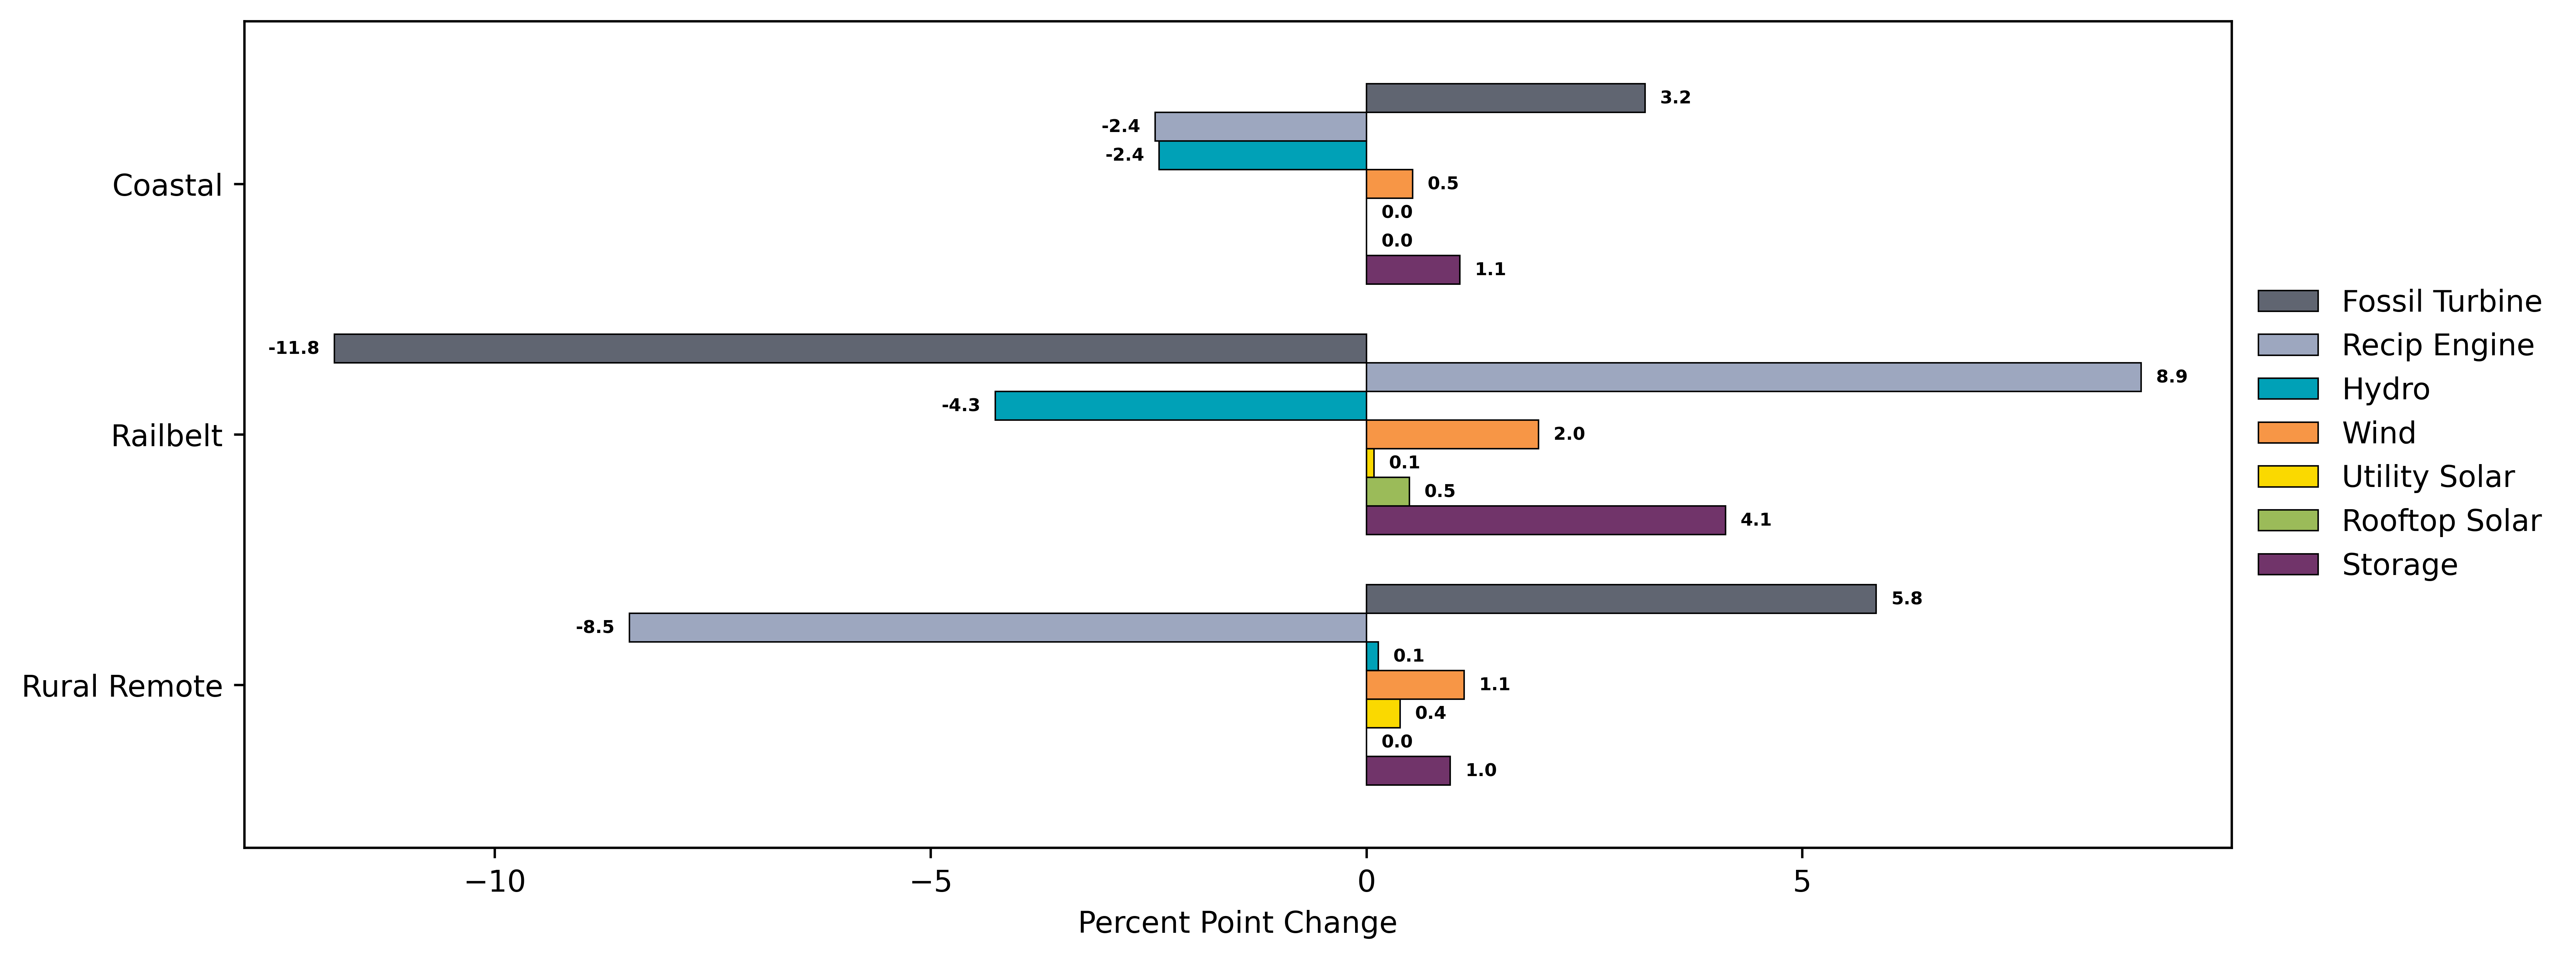

In [5]:
# Plotting the chart to show % increases and decreases by fuel type
fig, ax = plt.subplots(figsize=(6.5, 5), layout="none")
fig.set_dpi(600)
p.plot(
    kind="barh",
    y=reversed(p.columns.tolist()),
    rot=0,
    width=0.8,
    align="center",
    edgecolor="black",
    linewidth=0.5,
    color=schemes['prime_movers'],
    ax=ax,
)
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="{:.1f}",
        fontsize=6,
        fontweight="bold",
        color="black",
        label_type="edge",
        padding=5,
    )
ax.set_xlabel("Percent Point Change")
ax.set_ylabel("")
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles),
    reversed(labels),
    bbox_to_anchor=(1, 0.5),
    loc="center left",
    frameon=False,
    ncol=1,
)
plt.subplots_adjust(right=1.55)
filename = os.path.join(os.curdir, "figures", "statewide-capacity-delta")
plt.savefig(filename + ".pdf", bbox_inches="tight")
plt.savefig(filename + ".png", bbox_inches="tight")

# Regional Capacity Trends

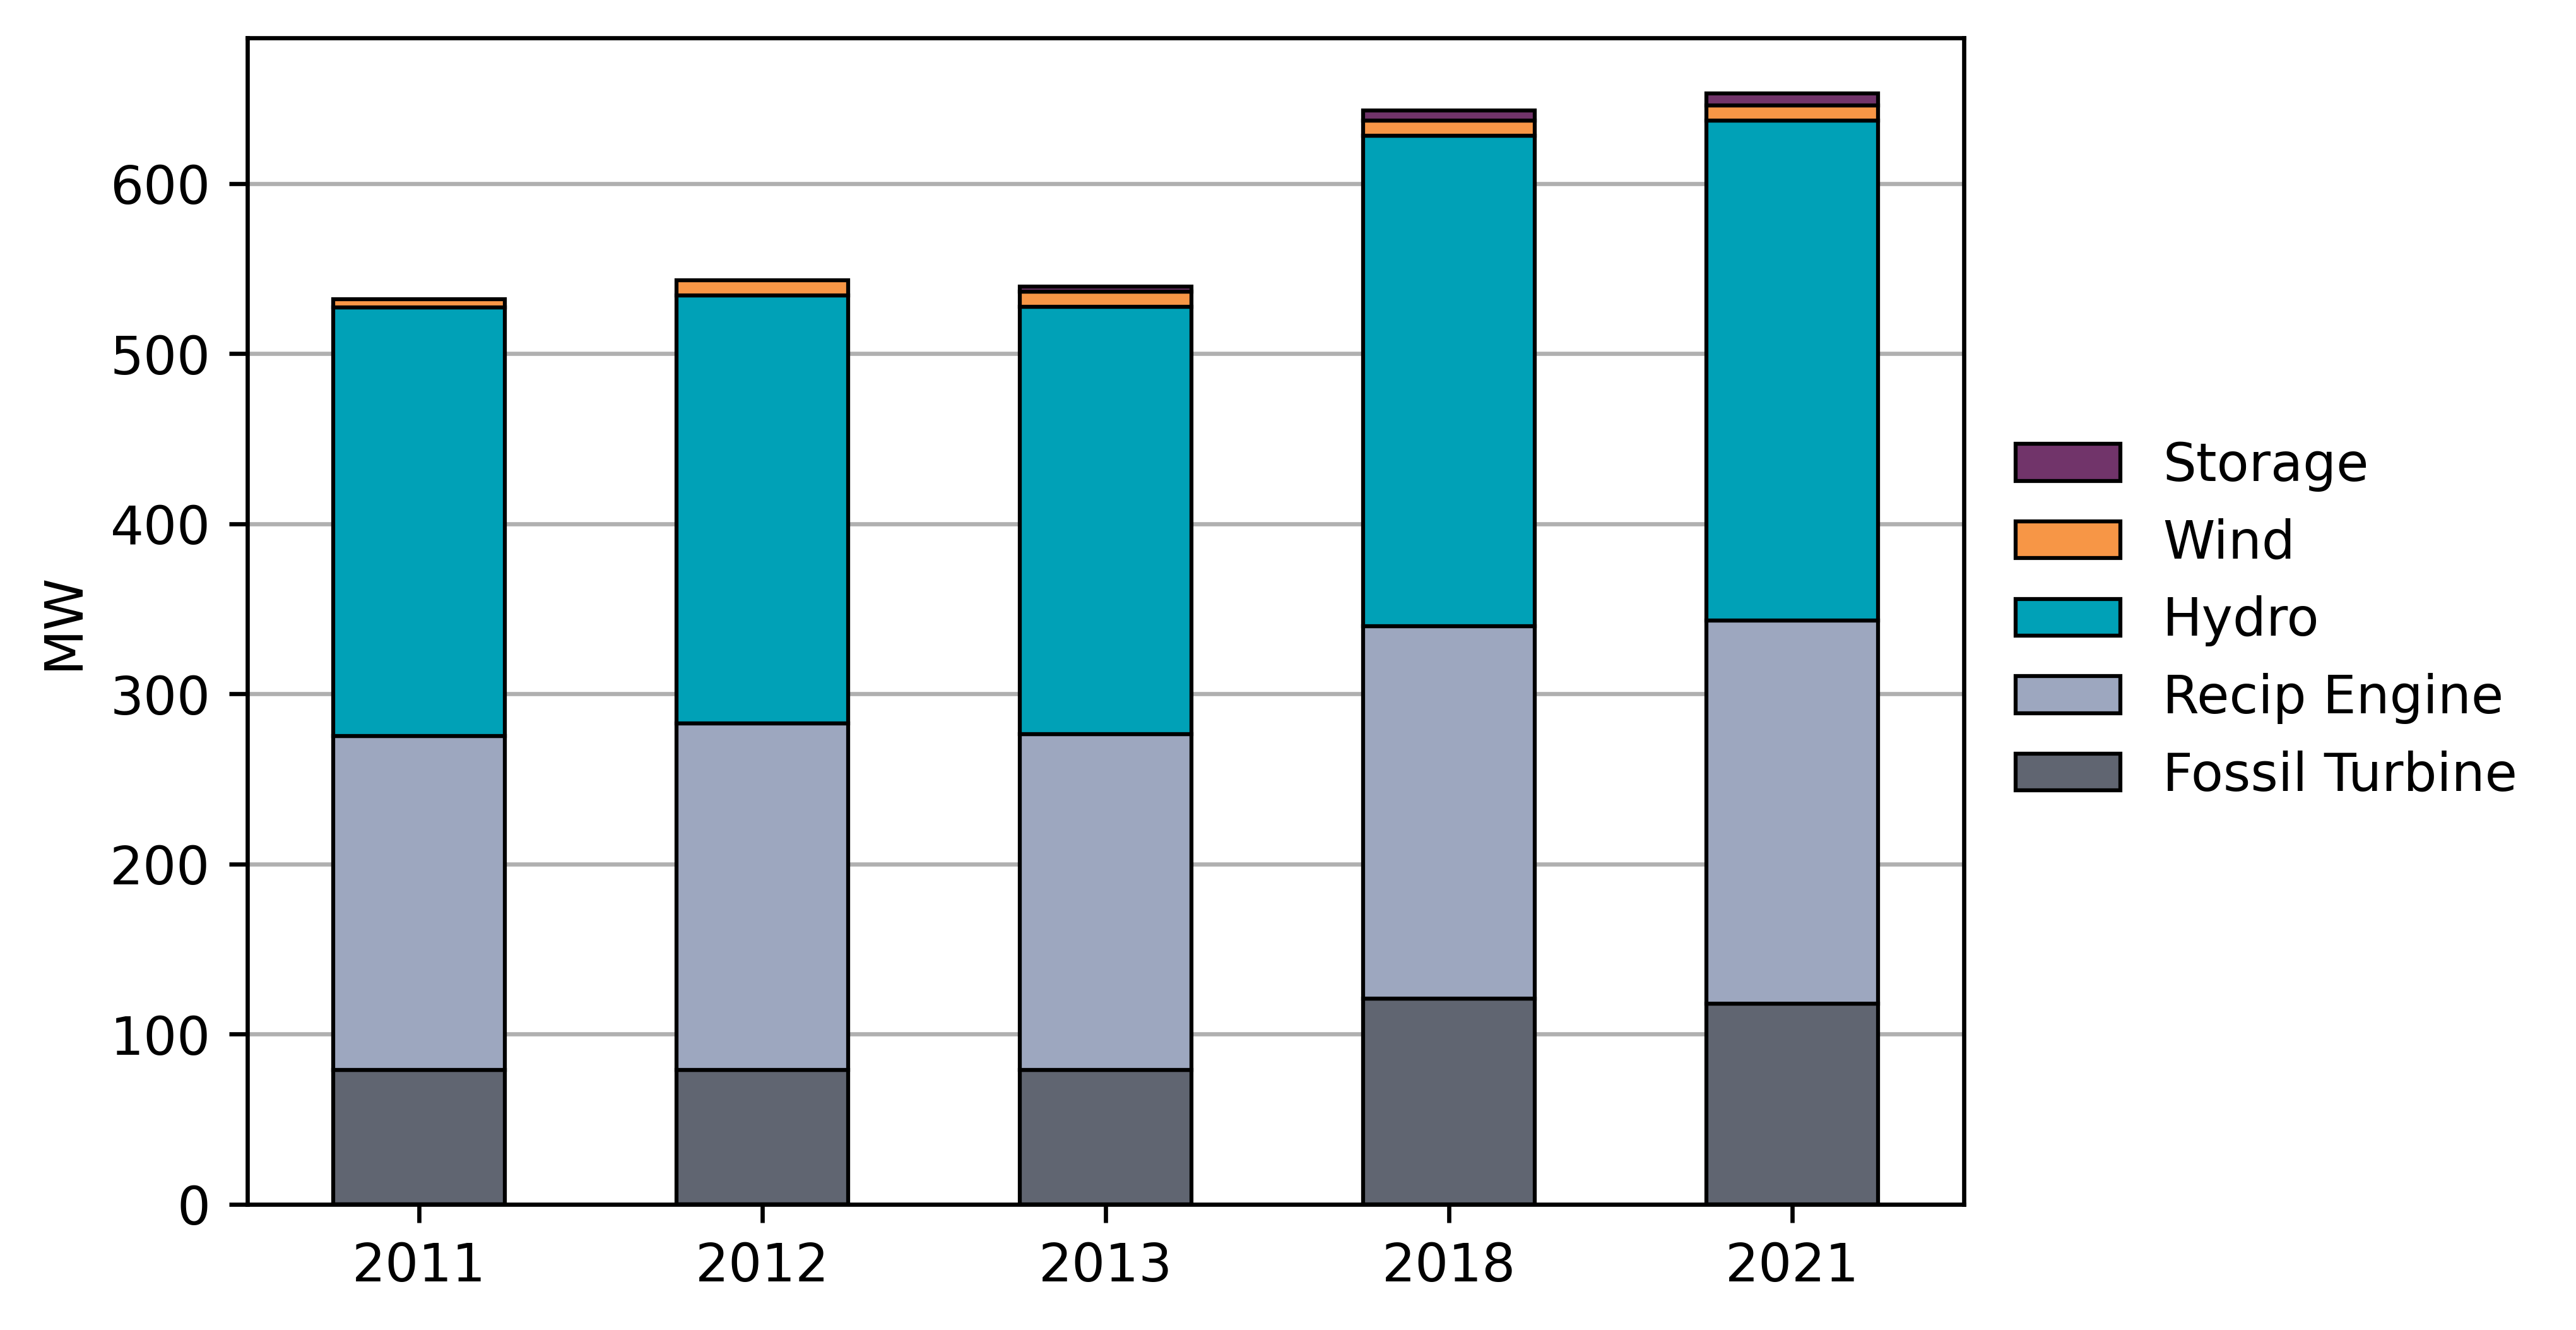

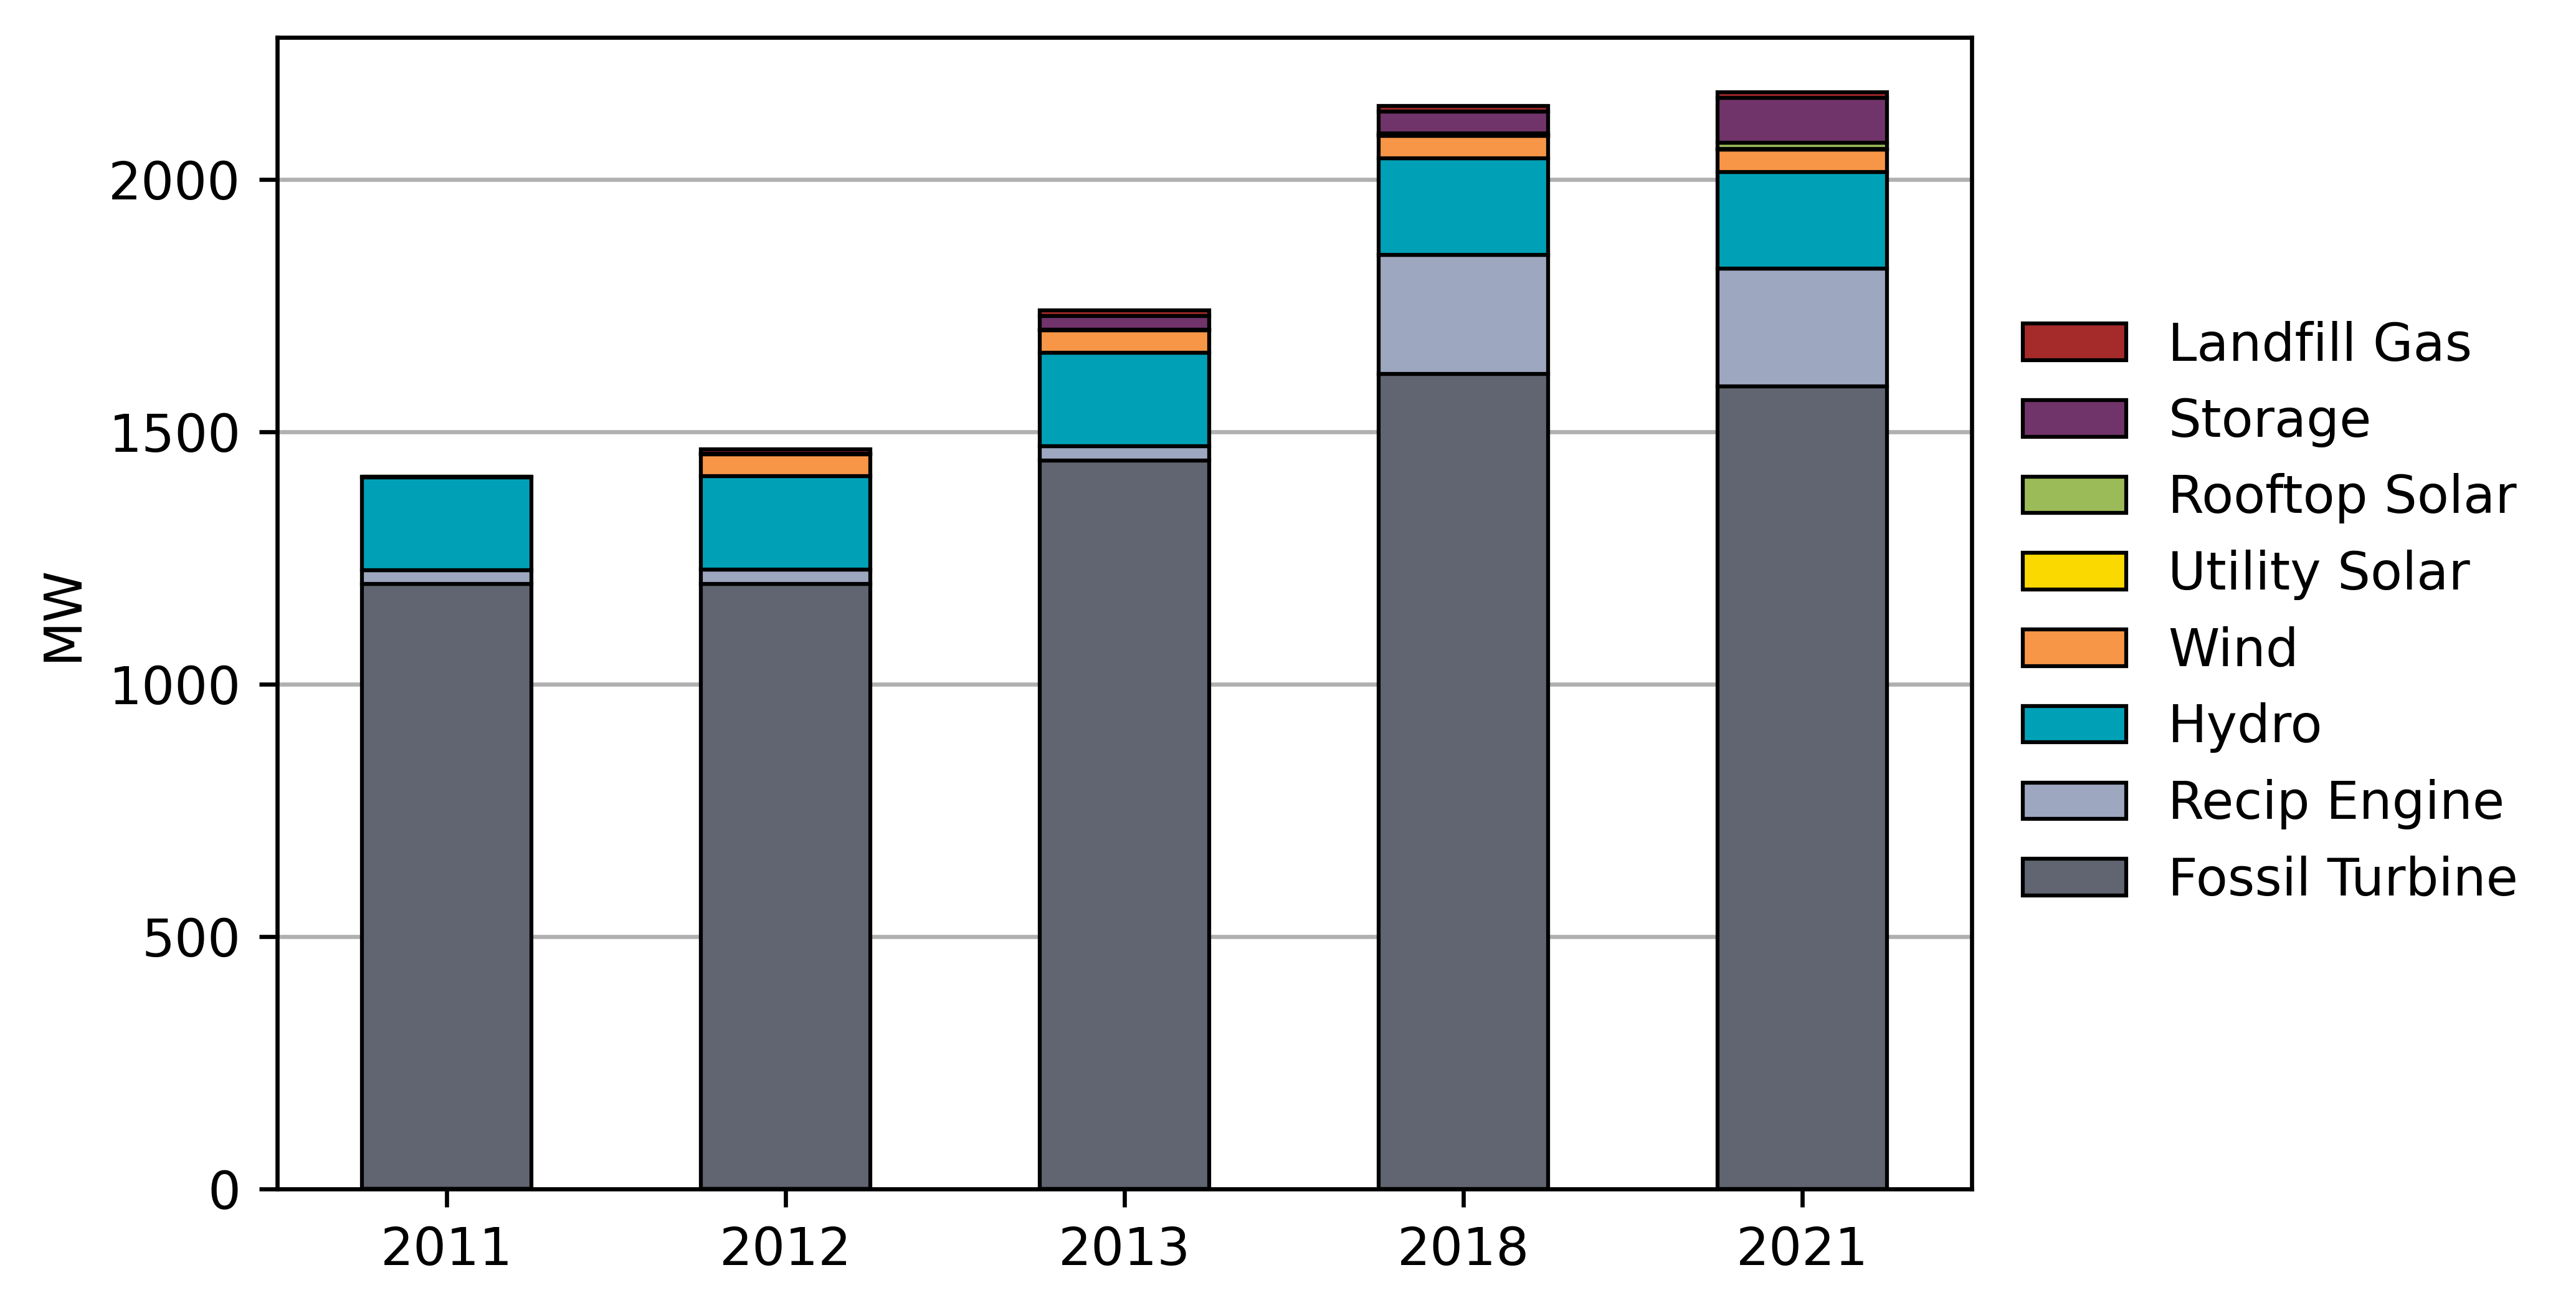

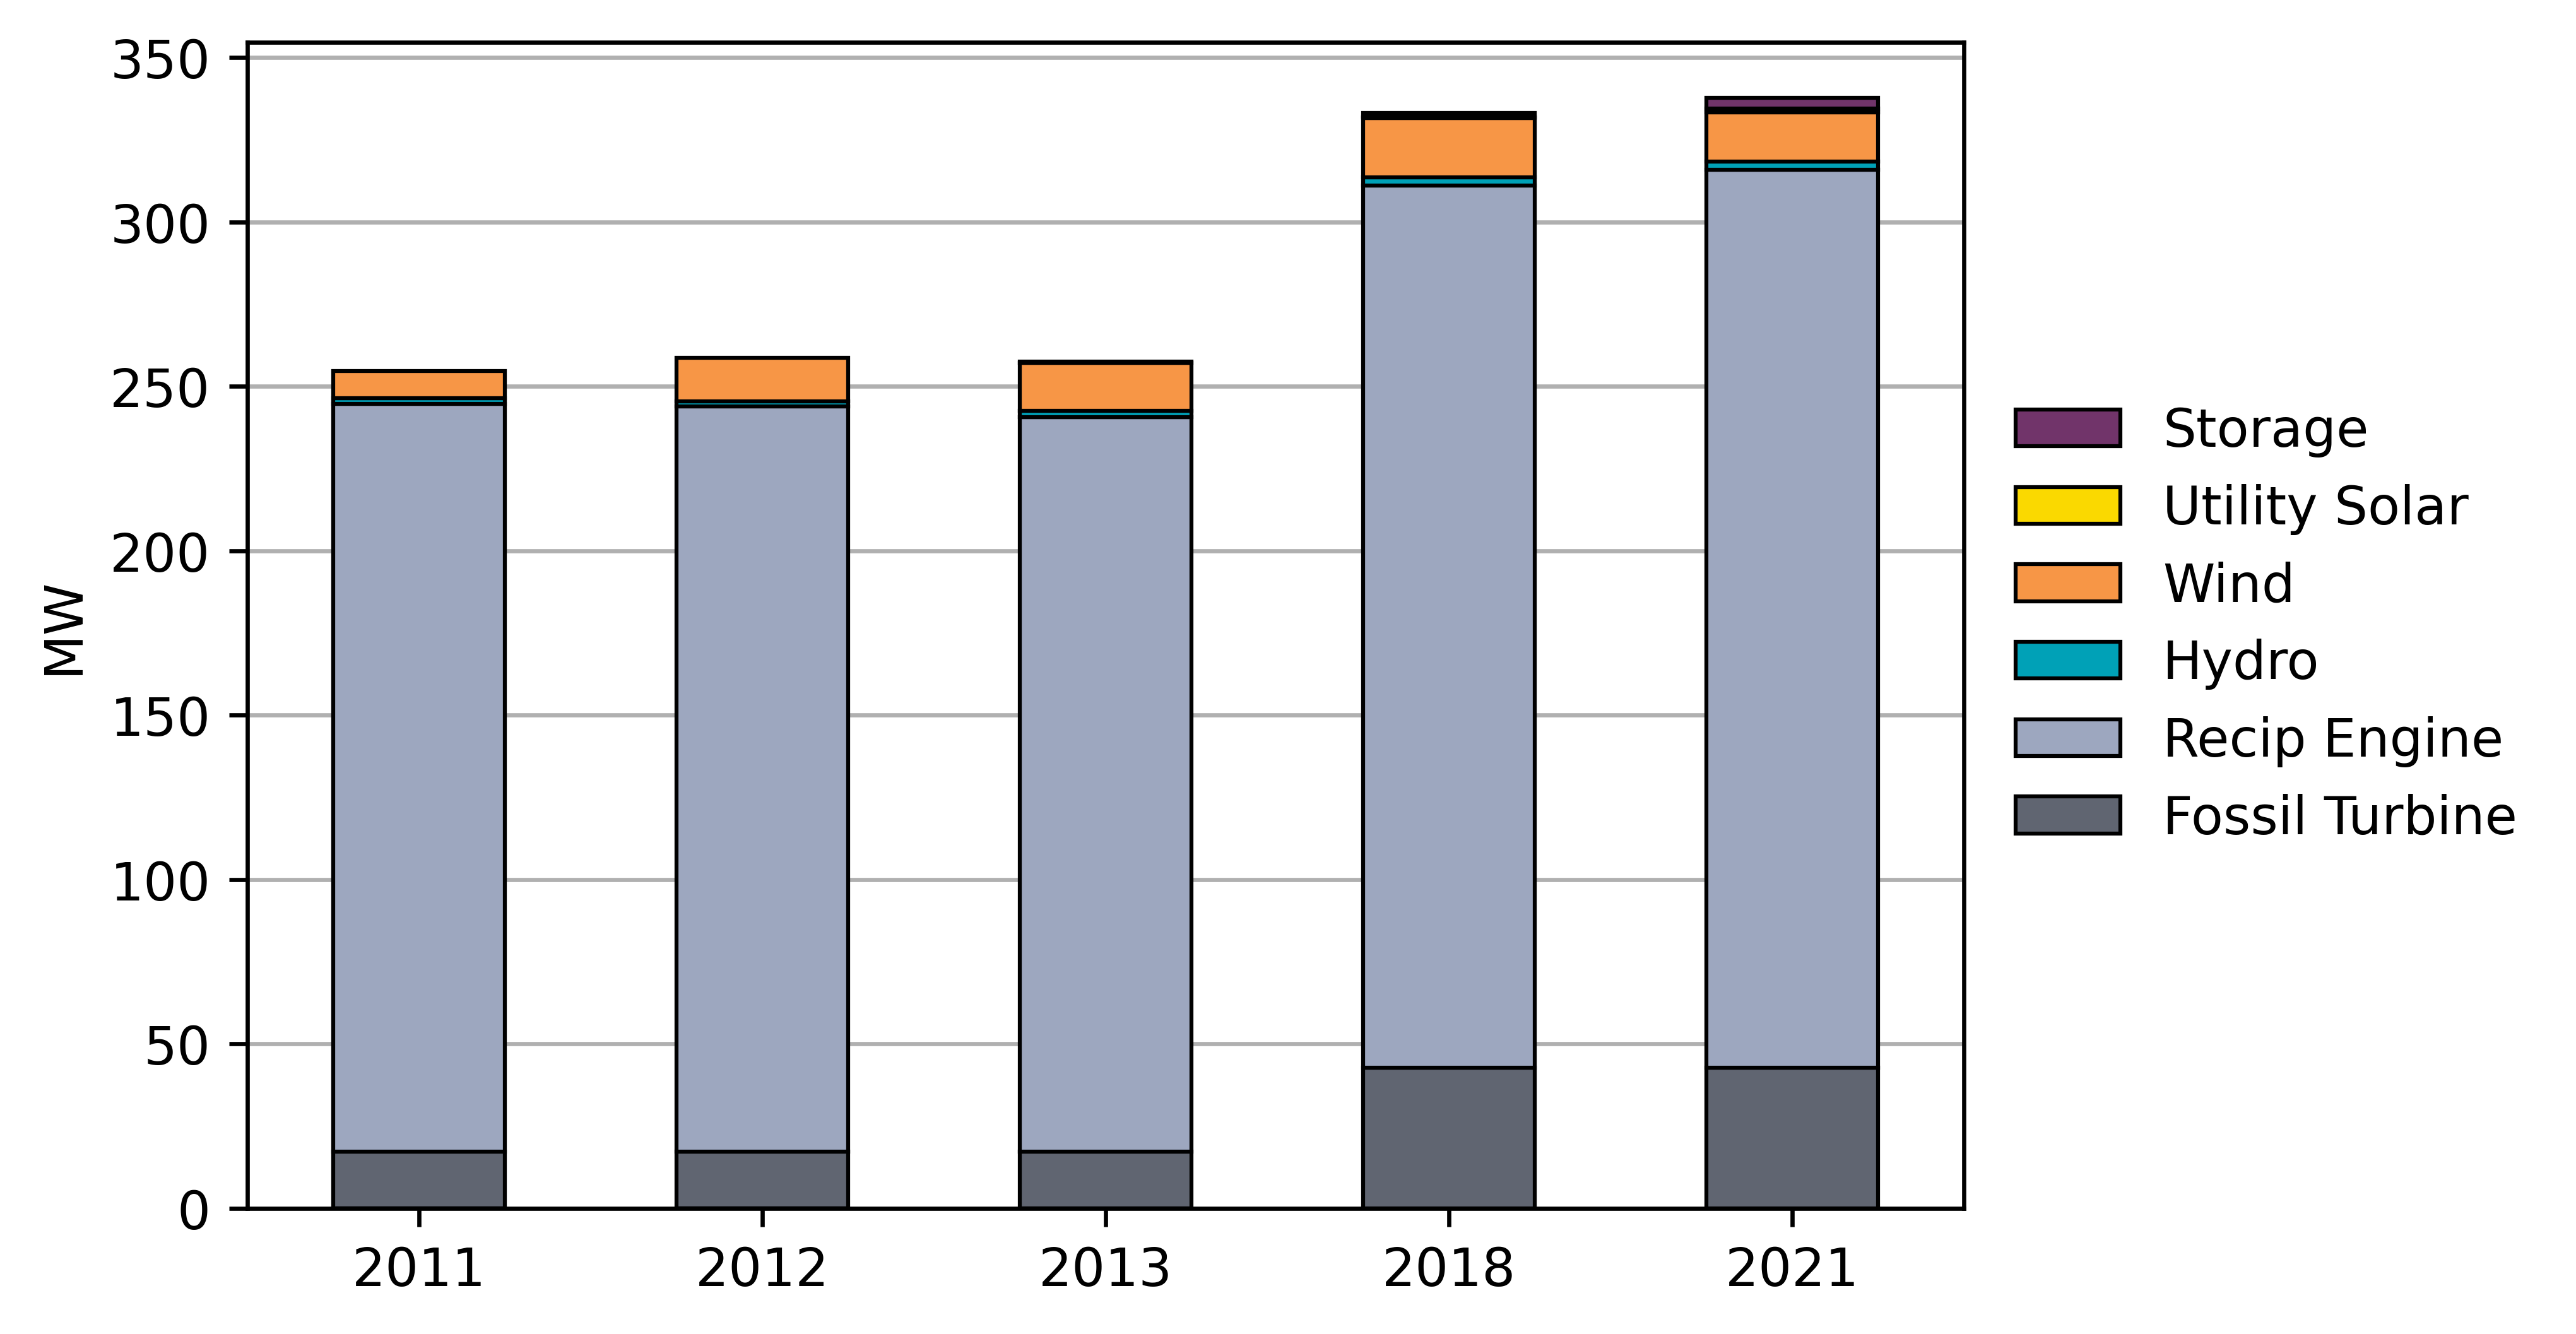

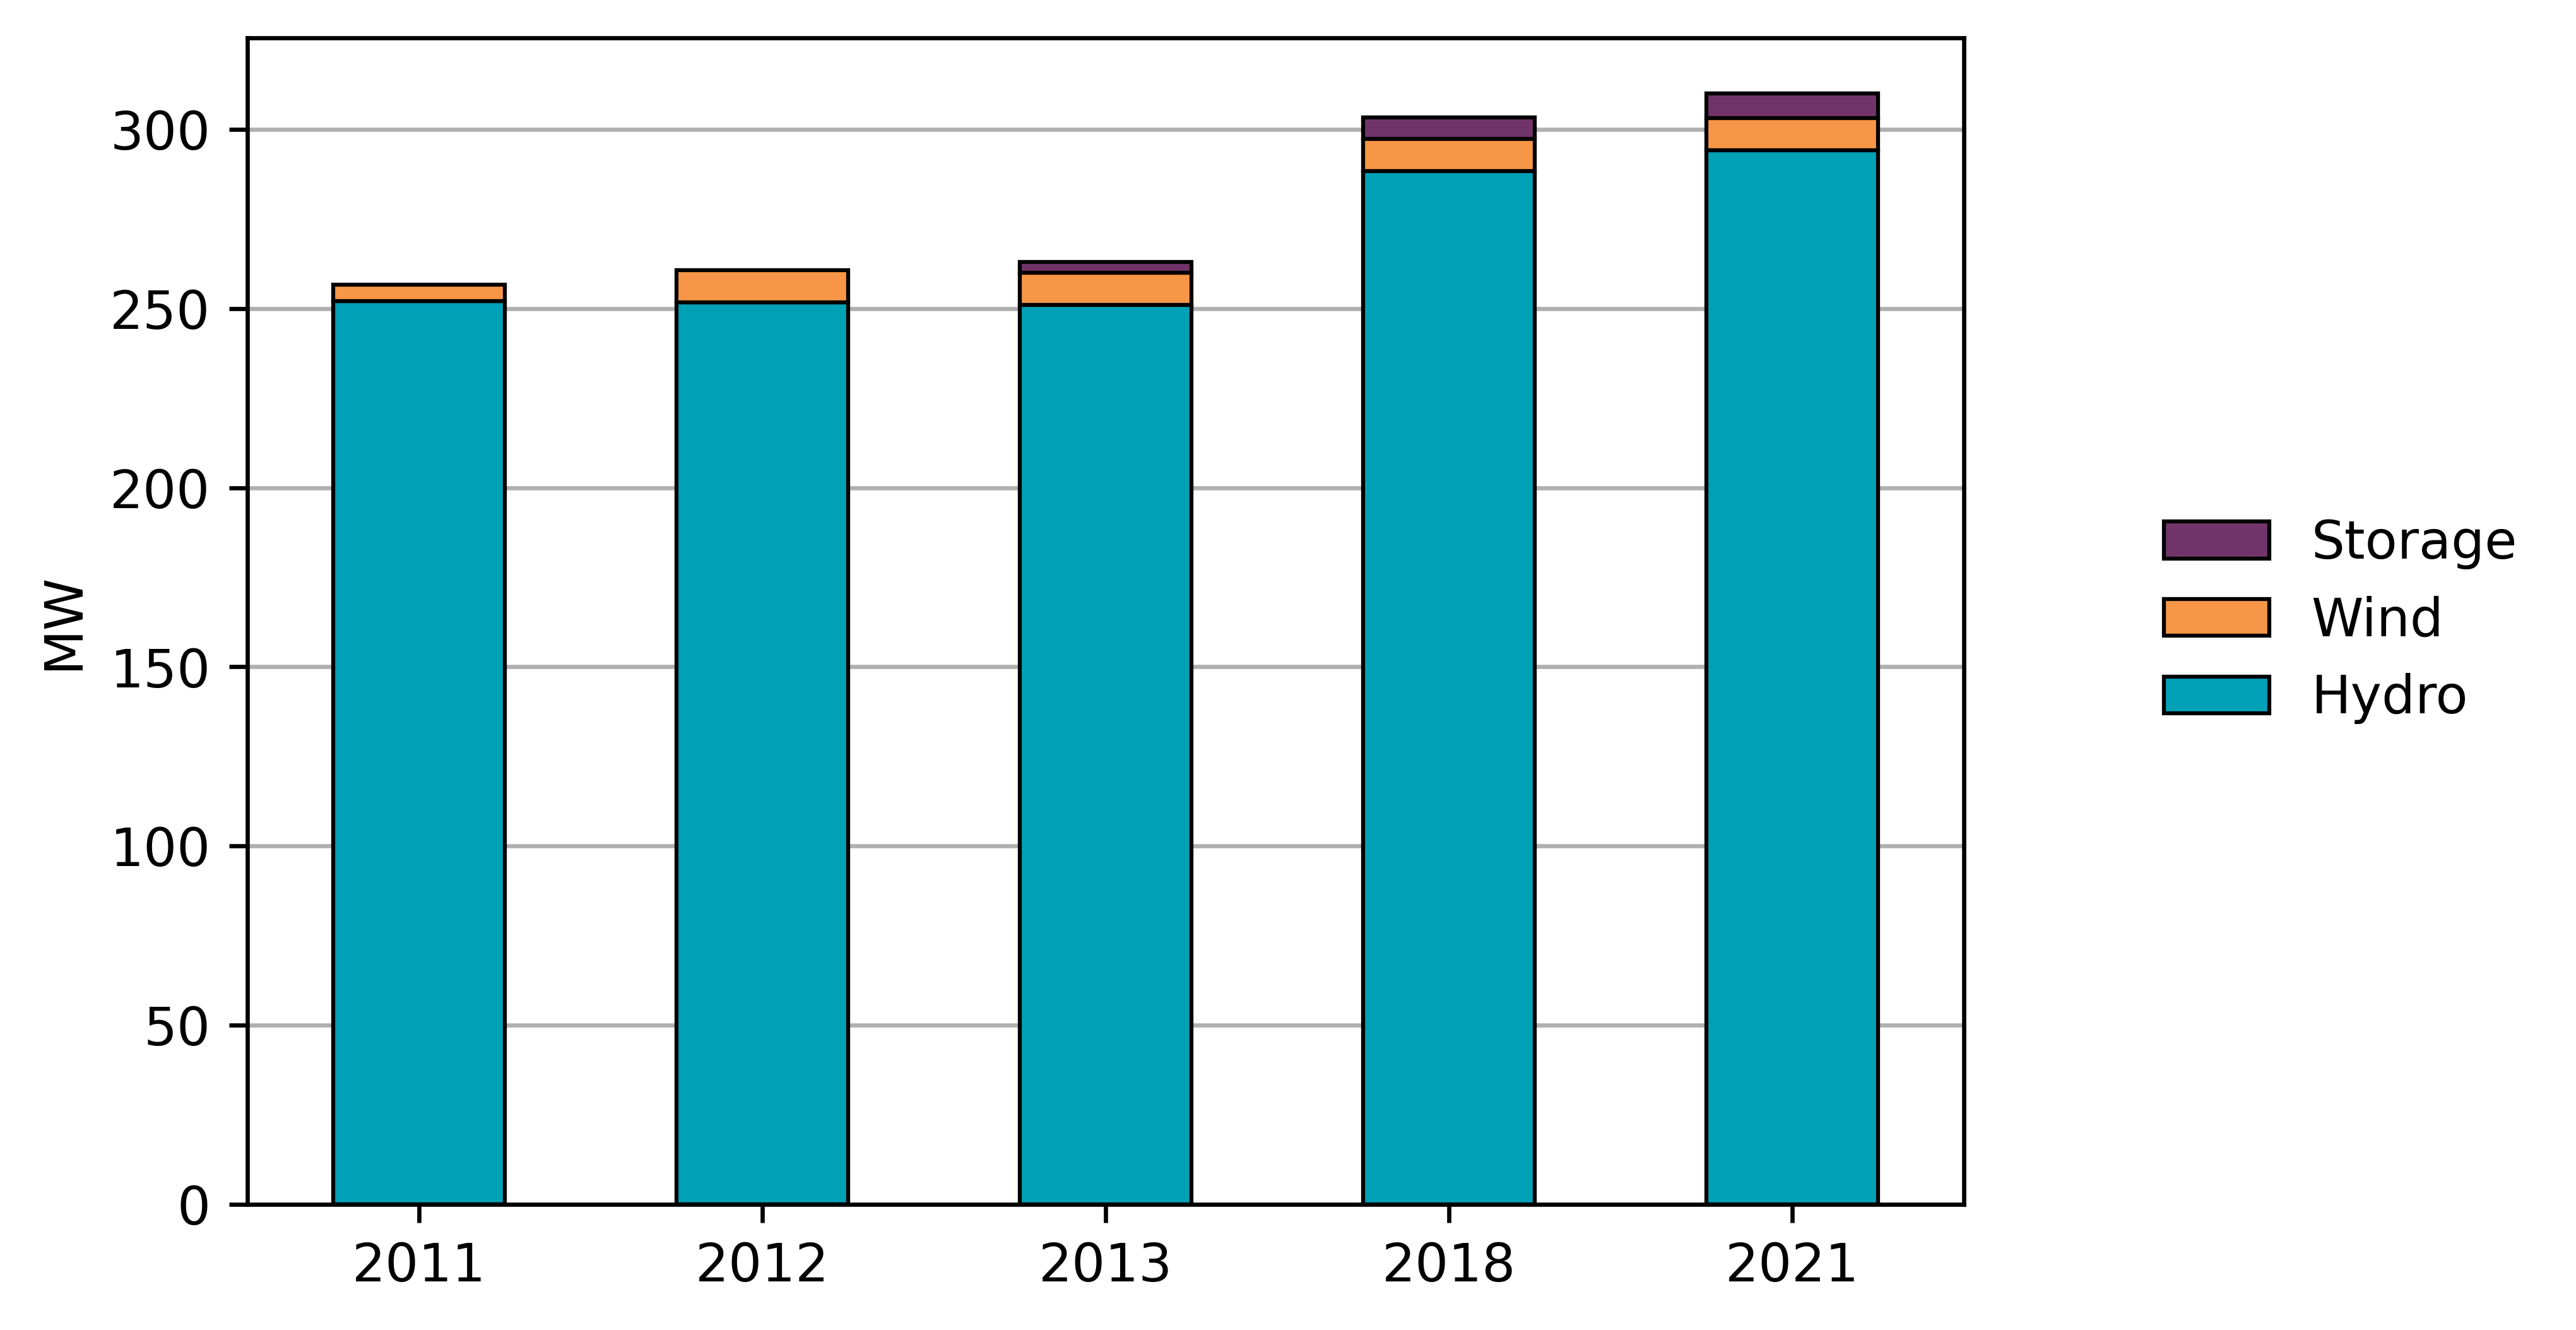

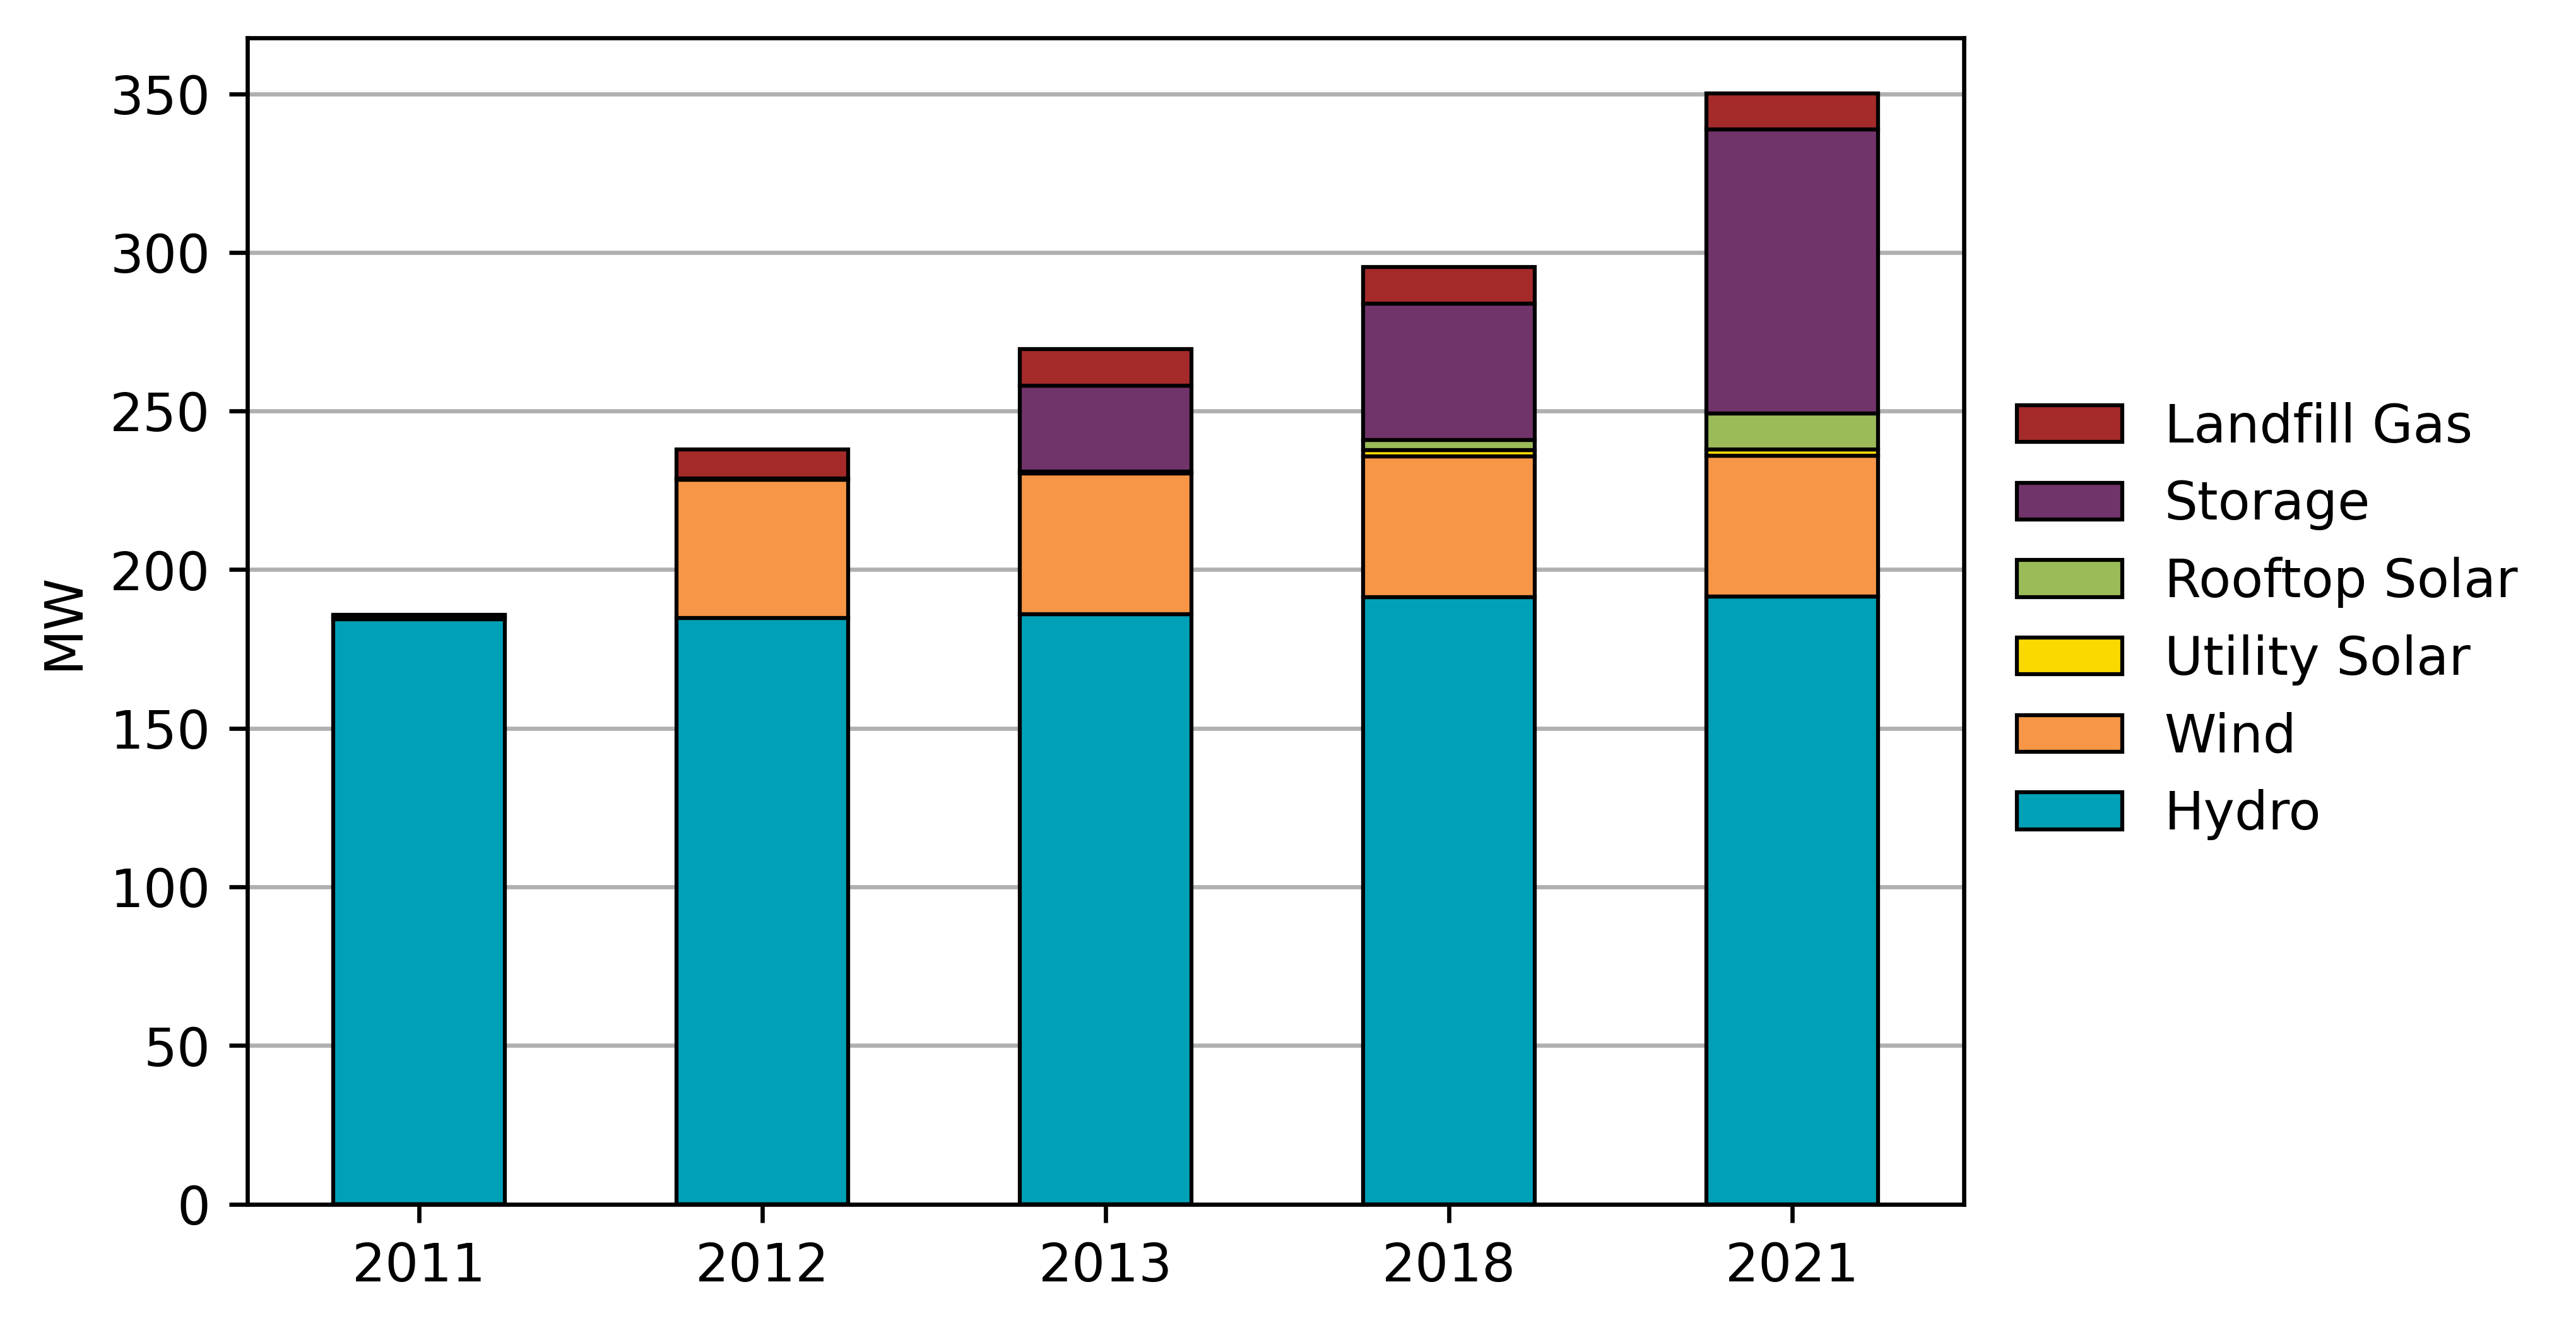

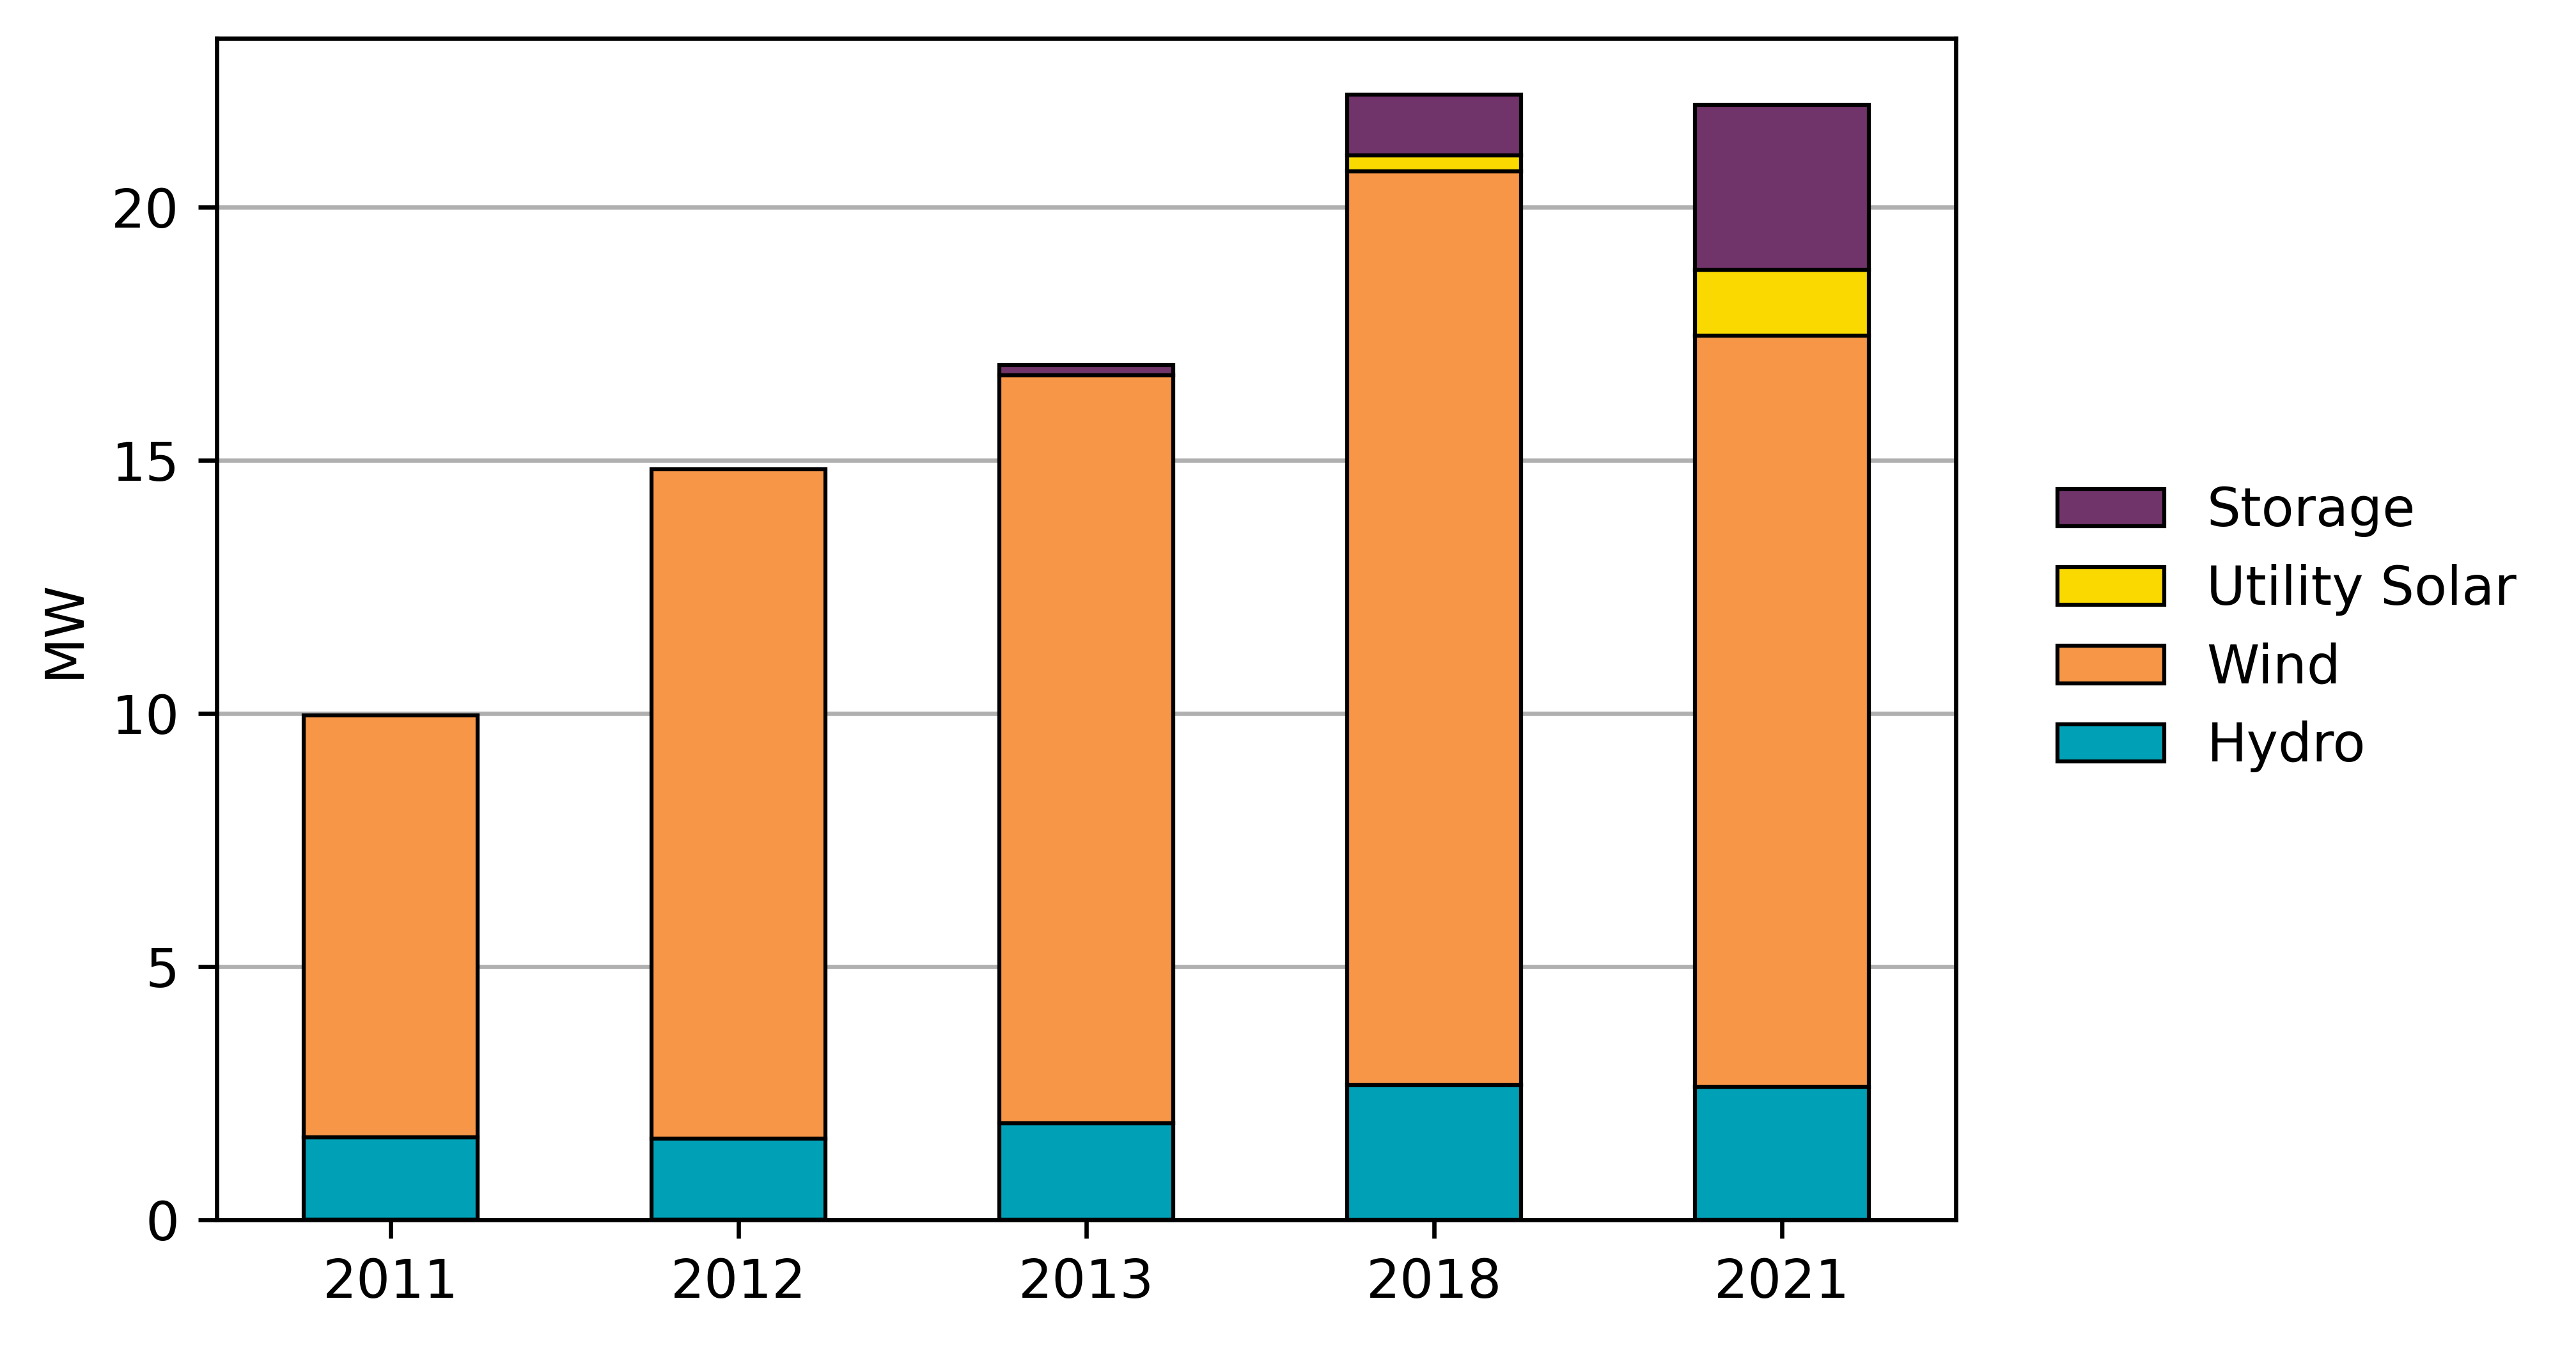

In [10]:
# Plotting the all capacity by prime mover and ACEP energy region
#   This section plots each subsections figure, both all prime movers and the non-fossil prime movers

# Creating a new slice
c = b.reset_index()  # reset the index for parsing
all_prime_movers = c.columns.to_list()[
    2:
]  # list of all resources for first subsection figure
renewable_other_prime_movers = c.columns.to_list()[
    4:
]  # non-turbine/engine resources for second subsection figure (relies on proper ordering of columns!)

# Plotting all prime movers
for i in c["acep-region"].unique():
    # Dynamic prime mover list for plotting
    # Objective is to only add columns to the list that is used fo the y-axis plotting that actually has capacity
    tmp = c[c["acep-region"] == i]
    dyn_prime_mover_list = []
    for x in c.columns.tolist()[2:]:
        if tmp[x].sum() > 0:
            dyn_prime_mover_list += [x]
        else:
            pass

    # Figure creation based on the dynamic prime mover list
    fig, ax = plt.subplots(figsize=(6.5, 4), layout="constrained")
    fig.set_dpi(600)
    tmp.plot(
        kind="bar",
        y=dyn_prime_mover_list,
        x="year",
        stacked=True,
        rot=0,
        edgecolor="black",
        color=schemes['prime_movers'],
        linewidth=0.75,
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel("MW")
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles),
        reversed(labels),
        loc="center right",
        bbox_to_anchor=(1.35, 0.5),
        ncol=1,
        frameon=False,
    )
    filename = os.path.join(
        os.curdir, "figures", i.lower().replace(" ", "-") + "-capacity"
    )
    plt.savefig(filename + ".pdf", bbox_inches="tight")
    plt.savefig(filename + ".png", bbox_inches="tight")

# Plotting non-fossil prime movers
for i in c["acep-region"].unique():
    # Dynamic prime mover list for plotting
    # Objective is to only add columns to the list that is used fo the y-axis plotting that actually has capacity
    tmp = c[c["acep-region"] == i]
    dyn_prime_mover_list = []
    for x in c.columns.tolist()[4:]:
        if tmp[x].sum() > 0:
            dyn_prime_mover_list += [x]
        else:
            pass

    # Figure creation based on the dynamic prime mover list
    fig, ax = plt.subplots(figsize=(6.5, 4), layout="constrained")
    fig.set_dpi(600)
    c[c["acep-region"] == i].plot(
        kind="bar",
        y=dyn_prime_mover_list,
        x="year",
        stacked=True,
        rot=0,
        edgecolor="black",
        color=schemes['prime_movers'],
        linewidth=0.75,
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel("MW")
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles),
        reversed(labels),
        loc="center right",
        bbox_to_anchor=(1.35, 0.5),
        ncol=1,
        frameon=False,
    )
    filename = os.path.join(
        os.curdir, "figures", i.lower().replace(" ", "-") + "-capacity-non-fossil"
    )
    plt.savefig(filename + ".pdf", bbox_inches="tight")
    plt.savefig(filename + ".png", bbox_inches="tight")

In [11]:
# Producing a table for the capacity subsections
round(c,2).to_csv(os.path.join(os.curdir,'tables','capacity-by-region.csv'),index=False)

In [12]:
# Producing in-text capacity references
for i in c["acep-region"].unique():
    print(i)
    for j in c.columns.tolist()[2:]:
        print(
            j,
            round(
                c[c["acep-region"] == i].iloc[4][j]
                - c[c["acep-region"] == i].iloc[0][j]
            ),
            "MW",
        )
    print(os.linesep)

Coastal
Fossil Turbine 39 MW
Recip Engine 29 MW
Hydro 42 MW
Wind 4 MW
Utility Solar 0 MW
Rooftop Solar 0 MW
Storage 7 MW
Landfill Gas 0 MW


Railbelt
Fossil Turbine 390 MW
Recip Engine 207 MW
Hydro 7 MW
Wind 43 MW
Utility Solar 2 MW
Rooftop Solar 11 MW
Storage 90 MW
Landfill Gas 12 MW


Rural Remote
Fossil Turbine 25 MW
Recip Engine 46 MW
Hydro 1 MW
Wind 7 MW
Utility Solar 1 MW
Rooftop Solar 0 MW
Storage 3 MW
Landfill Gas 0 MW


